Initial analysis began with parsing through the data. The following two functions were created for loading, binning, and calculating the moving average per trial of the data 

In [5]:
# Install required packages
!pip install numpy scipy scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 15.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.8 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 8.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 16.2 MB/s eta 0:00:0000:0100:01


In [6]:
import numpy as np
from scipy.io import loadmat

def load_data(mat_file):

    #load mat file
    data=loadmat(mat_file)

    #add categories for the following data bins
    data['stimulusTimesRaster'] = []
    data['bpTimesRaster'] = []
    data['labels'] = []
    data['trialAvgStimulus'] = []
    data['trialAvgBp'] = []
    data['spikeRatesStim'] = [] #this is for the whole time window on the PSTH plot (2 seconds)
    data['spikeRatesBp'] = []   #this is for the whole time window on the PSTH plot (2 seconds)
    data['stimSpikeCount'] = [] #this is over the .5seconds after stimulus onset; divide by 0.5 for spike rate
    data['bpSpikeCount'] = []  #Important note: this is ONLY for the button press window and is the same as the total spike count since it's divided by 1 (1 second after button press)

    #flatten the 2D events array
    data['events'] = np.concatenate((data['events'][:, 0], data['events'][:, 1]))

    return data

#function for calculating the moving average
def moving_avg(stimulusStartTime, data, i, stimulusEndTime, binSize, stepSize):
    
    stimulusStartTime = stimulusStartTime - binSize*1_000   #increase time window to prevent dropping off look on graphs
    stimulusEndTime = stimulusEndTime + binSize*1_000

    timeStamp=stimulusStartTime

    trialAvg= []        #numpy array to store 100 values from loop of running averages

    #iterate over the all 100 time stamps between start and end 
    #in addition to 5 time stamps padded onto start and end time
    total_itr = int((stimulusEndTime - stimulusStartTime)/(stepSize*1_000))
    
    for j in range(total_itr):
        binEnd=timeStamp + binSize/2*1_000      #microseconds
        binStart=timeStamp - binSize/2*1_000    #microseconds
        
        if binEnd > stimulusEndTime:
            binEnd=stimulusEndTime
        
        if binStart < stimulusStartTime:
            binStart=stimulusStartTime 
        
        stimulusTimes=data['timestampsOfCell'][(data['timestampsOfCell'] >= binStart) & (data['timestampsOfCell'] <= binEnd)]
        stimulusTimes=stimulusTimes-data['events'][i]
        if (timeStamp>=(stimulusStartTime + binSize*1_000)) and (timeStamp<=(stimulusEndTime - binSize*1_000)):
            if len(trialAvg) < (total_itr - (binSize/stepSize*2)):     
                spikeCount= len(stimulusTimes)
                trialAvg.append(spikeCount)
        timeStamp=timeStamp+stepSize*1_000      #microseconds
    #print(len(trialAvg))
    return trialAvg

def bin_data(data):

    #create dictionarys to store the three categories                   
    correctCongruent =  {'stimulusTimesRaster': [], 'bpTimesRaster': [], 'stimSpikeCount': [], 
                         'bpSpikeCount':[], 'spikeRates':[],'movingAvgStimulus':[],'movingAvgBp':[],'trial':[]}     
    correctIncongruent= {'stimulusTimesRaster': [], 'bpTimesRaster': [], 'stimSpikeCount': [], 
                         'bpSpikeCount':[], 'spikeRates':[],'movingAvgStimulus':[],'movingAvgBp':[],'trial':[]}
    error = {'stimulusTimesRaster': [], 'bpTimesRaster': [],'stimSpikeCount': [], 
                         'bpSpikeCount':[],'spikeRates':[],'movingAvgStimulus':[],'movingAvgBp':[],'trial':[]}
    
    #button press event times were flattened from 2d array to 1d-> need length of data set to correctly index
    bpIndex = int(len(data['events'])/2)

    #global variables
    BIN_SIZE = 200      #200ms
    STEP_SIZE = 20      #20ms
    TIME_WINDOW = 2

    for i in range(len(data['answers'])):

        stimulusStartTime, stimulusEndTime = data['events'][i] - (0.5 * 1_000_000), data['events'][i] + (1.5 * 1_000_000)
        bpStartTime, bpEndTime = data['events'][i + bpIndex] - (0.5 * 1_000_000), data['events'][i + bpIndex] + (1.5 * 1_000_000)

        trialAvgStimulus = moving_avg(stimulusStartTime, data, i, stimulusEndTime, BIN_SIZE, STEP_SIZE)
        data['trialAvgStimulus'].append(trialAvgStimulus)

        trialAvgBp = moving_avg(bpStartTime, data, i, bpEndTime, BIN_SIZE, STEP_SIZE)
        data['trialAvgBp'].append(trialAvgBp)

        #stimulus spike times in time window, relative to event time
        stimulusTimesRaster=data['timestampsOfCell'][(data['timestampsOfCell'] >= stimulusStartTime) & (data['timestampsOfCell'] <= stimulusEndTime)]-data['events'][i]  
        stimTimesSpikeCount=data['timestampsOfCell'][(data['timestampsOfCell'] >= stimulusStartTime +(0.5 * 1_000_000)) & (data['timestampsOfCell'] <= stimulusEndTime-(1.0 *1_000_000))]-data['events'][i]

        data['stimulusTimesRaster'].append(stimulusTimesRaster)
        data['stimSpikeCount'].append(len(stimTimesSpikeCount))

        #append the spike rate-> I think it's 2 b/c that's the whole time window
        data['spikeRatesStim'].append(len(stimulusTimesRaster)/TIME_WINDOW)

        #bp spike times in time window, relative to event time
        bpTimesRaster=data['timestampsOfCell'][(data['timestampsOfCell'] >= bpStartTime) & (data['timestampsOfCell'] <= bpEndTime)]-data['events'][i+bpIndex]
        bpTimesSpikeCount=data['timestampsOfCell'][(data['timestampsOfCell'] >= bpStartTime + (0.5 * 1_000_000)) & (data['timestampsOfCell'] <= bpEndTime-(.5*1_000_000))]-data['events'][i+bpIndex]

        data['bpTimesRaster'].append(bpTimesRaster)
        data['bpSpikeCount'].append(len(bpTimesSpikeCount))
        
        #append the spike rate-> I think it's 2 b/c that's the whole time window
        data['spikeRatesBp'].append(len(bpTimesRaster)/TIME_WINDOW)
        
        if data['answers'][i] == data['colorsPresented'][i]:
            data['labels'].append(1)
            if (data['colorsPresented'][i]==data['textsPresented'][i]):
                #correct congruent -> add whatever other data needed here
                correctCongruent['trial'].append(i)
                correctCongruent['stimulusTimesRaster'].append(data['stimulusTimesRaster'][i])
                correctCongruent['bpTimesRaster'].append(data['bpTimesRaster'][i])
                correctCongruent['stimSpikeCount'].append(data['stimSpikeCount'][i])
                correctCongruent['bpSpikeCount'].append(data['bpSpikeCount'][i])
                correctCongruent['movingAvgStimulus'].append(data['trialAvgStimulus'][i])
                correctCongruent['movingAvgBp'].append(data['trialAvgBp'][i])

            else:
                #incorrect congruent -> add whatever other data needed here
                correctIncongruent['trial'].append(i)
                correctIncongruent['stimulusTimesRaster'].append(data['stimulusTimesRaster'][i])
                correctIncongruent['bpTimesRaster'].append(data['bpTimesRaster'][i])
                correctIncongruent['stimSpikeCount'].append(data['stimSpikeCount'][i])
                correctIncongruent['bpSpikeCount'].append(data['bpSpikeCount'][i])
                correctIncongruent['movingAvgStimulus'].append(data['trialAvgStimulus'][i])
                correctIncongruent['movingAvgBp'].append(data['trialAvgBp'][i])
        
        else:
            #add label for incorrect trial-> 0 (roc curve)
            data['labels'].append(0)
            error['trial'].append(i)
            #error trials -> add whatever other data needed here
            error['stimulusTimesRaster'].append(data['stimulusTimesRaster'][i])
            error['bpTimesRaster'].append(data['bpTimesRaster'][i])
            error['stimSpikeCount'].append(data['stimSpikeCount'][i])
            error['bpSpikeCount'].append(data['bpSpikeCount'][i])
            error['movingAvgStimulus'].append(data['trialAvgStimulus'][i])
            error['movingAvgBp'].append(data['trialAvgBp'][i])
    

    return data, error, correctCongruent, correctIncongruent


The following functions calculated the moving average across all trials, performed an roc analysis based on spike rates and error type, and performed a t_test. 

In [7]:
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

#function to calculate the average across all trials stored in a dictionary
def calc_avg(moving_avg, target_shape):

    moving_avg_arr= np.array(moving_avg)
    
    if moving_avg_arr.size>0:
        moving_avg_arr=np.mean(moving_avg_arr, axis=0)
    else:
        print("no data available for averaging")
        return np.zeros(target_shape)

    return moving_avg_arr

def roc_analysis(data_spike_rates, data_labels, time_window):
    spikeRatesStim=np.array(data_spike_rates)/time_window
    labels=np.array(data_labels)
    
    if labels.size ==0 or spikeRatesStim.size==0:
        print("Empty data, ROC analysis cannot be performed.")
        return None, None, None

    #Check if labels contain at least two class (some trials had no errors)
    if len(np.unique(labels)) < 2:
        print('Only one type found in labels, ROC analysis not performed')
        return None, None, None
    
    #choose a logistic regression classifer for a binary choice-> error or correct based on the spike rates
    classifier = LogisticRegression()
    classifier.fit(spikeRatesStim.reshape(-1,1),labels)
    probabilities = classifier.predict_proba(spikeRatesStim.reshape(-1,1))[:,1]

    fpr, tpr, thresholds = roc_curve(labels,probabilities)
    roc_auc=auc(fpr, tpr)

    return fpr, tpr, roc_auc


def t_test(cc, ci, err, equalVar):

    cc, ci, err = np.array(cc), np.array(ci), np.array(err)
    
    if cc.size == 0 and ci.size == 0:
        print("No data for correct trials.")
        return None, None, None, None   
    
    correct = np.concatenate([cc, ci])

    if err.size >= 5 and correct.size >= 5:
        ce_tt, ce_pv = ttest_ind(correct, err, equal_var=equalVar)
    else:
        ce_tt, ce_pv=None, None
        print('Not enough data for error/correct ttest')
    if cc.size >= 5 and ci.size >= 5:
        ic_tt, ic_pv = ttest_ind(ci, cc, equal_var=equalVar)
    else: 
        ic_tt, ic_pv = None, None
        print('Not enough data for incongruent/congruent ttest')

    return ce_tt, ce_pv, ic_tt, ic_pv



Next, I visualized each neuron by creating a 6 plot PDF. For each neuron, I created functions for raster plots, moving average of spike rates plots, and ROC curve for error/correct classification in a logistic regression classifer plots. The three plots were used to visualize -5.seconds to 1.5 seconds after onset for both the stimulus and button press windows. A t_test was p

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
#from stats import calc_avg, roc_analysis, t_test

def plot_rasters(ax, data, color, start_index):
    for trialIndex, timesRaster in enumerate(data, start=start_index):
        ax.scatter(timesRaster / 1_000_000, [trialIndex] * len(timesRaster), color=color, s=2)

def plot_data(data, error, correctCongruent, correctIncongruent, file_name, output_folder):

    # Create a figure and axis for the raster and PSTH plot
    fig, axes = plt.subplots(
        nrows=3,ncols=2,figsize=(12, 16),
        sharex=False,
        gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [1, 1]}
    )
    ax, ax2, psth, psth2, roc, roc2 = axes.flat
    
    #share axis between psth and ax and psth2 and ax2
    psth.sharex(ax)
    psth2.sharex(ax2)

    # Define colors for each trial type
    errorColor = 'red'
    congruentColor = 'blue'
    incongruentColor = 'orange'

    #Raster for Stimulus ###################################################
    plot_rasters(ax, correctCongruent['stimulusTimesRaster'], congruentColor, 0)
    plot_rasters(ax, correctIncongruent['stimulusTimesRaster'], incongruentColor, len(correctCongruent['stimulusTimesRaster']))
    plot_rasters(ax, error['stimulusTimesRaster'], errorColor, len(correctCongruent['stimulusTimesRaster']) + len(correctIncongruent['stimulusTimesRaster']))
          
    #perform ttest and set plot title to results
    rce_ttest, rce_pvalue, ric_ttest, ric_pvalue = t_test(np.array(correctCongruent['stimSpikeCount']),np.array(correctIncongruent['stimSpikeCount']),np.array(error['stimSpikeCount']), equalVar=False)
    if len(error['trial']) >=5:
        if rce_ttest is not None and rce_pvalue is not None:
            ce_text = f'T-test (correct/error): t={rce_ttest:.2f}, p={rce_pvalue:.3f}\n'
        else:
            ce_text = 'Insufficient data for Correct/Error T-tests'
    else:
        ce_text = 'Insufficient data for Correct/Error T-tests' 
    if ric_ttest is not None and ric_pvalue is not None: 
        ci_text = f'T-test (incongruent/congruent): t={ric_ttest:.2f}, p={ric_pvalue:.3f}'
    else: 
        ci_text = 'Insufficient data for Incongruent/Congruent T-tests'
    
    ax.set_title(ce_text+'\n'+ci_text)
    
    # Add vertical grey line at x=0 (stimulus onset)
    ax.axvline(x=0, color='grey', linewidth=1)
    ax.set_ylabel('Trial Number')
    ax.set_xlabel('Time from Stimulus (s)')

    #Raster for Button Press################################################
    plot_rasters(ax2, correctCongruent['bpTimesRaster'], congruentColor, 0)
    plot_rasters(ax2, correctIncongruent['bpTimesRaster'], incongruentColor, len(correctCongruent['bpTimesRaster']))
    plot_rasters(ax2, error['bpTimesRaster'], errorColor, len(correctCongruent['bpTimesRaster']) + len(correctIncongruent['bpTimesRaster']))

    #perform ttest and set plot title to results
    rce2_ttest, rce2_pvalue, ric2_ttest, ric2_pvalue = t_test(
        np.array(correctCongruent['bpSpikeCount']),
        np.array(correctIncongruent['bpSpikeCount']),
        np.array(error['bpSpikeCount']), 
        equalVar=False
    )
    if len(error['trial']) >=5:
        if rce2_ttest is not None and rce2_pvalue is not None:
            ce2_text = f'T-test (correct/error): t={rce2_ttest:.2f}, p={rce2_pvalue:.3f}\n'
        else:
            ce2_text = 'Insufficient data for Correct/Error T-tests'
    else:
        ce2_text = 'Insufficient data for Correct/Error T-tests' 
    if ric2_ttest is not None and ric2_pvalue is not None: 
        ci2_text = f'T-test (incongruent/congruent): t={ric2_ttest:.2f}, p={ric2_pvalue:.3f}'
    else: 
        ci2_text = 'Insufficient data for Incongruent/Congruent T-tests'
    
    ax2.set_title(ce2_text+'\n'+ci2_text)

    # Add vertical grey line at x=0 (stimulus onset)
    ax2.axvline(x=0, color='grey', linewidth=1)
    ax2.set_xlabel('Time from Button Press (s)')
    
    #Create PSTH Plot
    psthTimes=np.arange(-.5,1.5,.02)

    #average calculations stimulus
    ccMovingAvgStimulus=calc_avg(correctCongruent['movingAvgStimulus'], target_shape=len(psthTimes))
    ciMovingAvgStimulus=calc_avg(correctIncongruent['movingAvgStimulus'],target_shape=len(psthTimes))
    errMovingAvgStimulus=calc_avg(error['movingAvgStimulus'],target_shape=len(psthTimes))

    psth.plot(psthTimes,ccMovingAvgStimulus/.2 if ccMovingAvgStimulus is not None else np.zeros_like(psthTimes), color=congruentColor,label='Correct Congruent')
    psth.plot(psthTimes,ciMovingAvgStimulus/.2 if ciMovingAvgStimulus is not None else np.zeros_like(psthTimes), color=incongruentColor, label='Incorrect Congruent')
    psth.plot(psthTimes,errMovingAvgStimulus/.2 if errMovingAvgStimulus is not None else np.zeros_like(psthTimes), color=errorColor, label='Error')
    psth.axvline(x=0, color='grey', linewidth=1)
    psth.set_ylabel('Spike Rate (Hz)')
    psth.set_xlabel('Time from Stimulus (s)')

    #average calculations button press
    ccMovingAvgBp=calc_avg(correctCongruent['movingAvgBp'],target_shape=len(psthTimes))
    ciMovingAvgBp=calc_avg(correctIncongruent['movingAvgBp'],target_shape=len(psthTimes))
    errMovingAvgBp=calc_avg(error['movingAvgBp'],target_shape=len(psthTimes))

    psth2.plot(psthTimes,ccMovingAvgBp/.2 if ccMovingAvgBp is not None else np.zeros_like(psthTimes), color=congruentColor,label='Correct Congruent')
    psth2.plot(psthTimes,ciMovingAvgBp/.2 if ciMovingAvgBp is not None else np.zeros_like(psthTimes), color=incongruentColor, label='Incorrect Congruent')
    psth2.plot(psthTimes,errMovingAvgBp/.2 if errMovingAvgBp is not None else np.zeros_like(psthTimes), color=errorColor, label='Error')
    psth2.axvline(x=0, color='grey', linewidth=1)
    psth2.set_xlabel('Time from Button Press (s)')

    #Roc analysis:
    fpr, tpr, roc_auc = roc_analysis(data['stimSpikeCount'],data['labels'], time_window=0.5)
    fpr2, tpr2, roc_auc2 = roc_analysis(data['bpSpikeCount'],data['labels'], time_window=1.0)
    
    if fpr is not None and tpr is not None: 
        roc.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        roc.plot([0,1],[0,1], linestyle='--',label='Reference Line')
        roc.set_xlabel('False Positive Rate')
        roc.set_ylabel('True Positive Rate')
        roc.set_title('Logistic Regression: Error/Correct Classification of \n Spike Rates for Stimulus Time Window (0,.5s)')
        roc.legend()
    if fpr2 is not None and tpr2 is not None: 
        roc2.plot(fpr2, tpr2, label=f'ROC Curve (AUC = {roc_auc2:.2f})')
        roc2.plot([0,1],[0,1], linestyle='--',label='Reference Line')
        roc2.set_xlabel('False Positive Rate')
        roc2.set_title('Logistic Regression: Error/Correct Classification of \n Spike Rates for Button Press Window (0,1s)')
        roc2.legend()

    #title the whole figure
    fig.suptitle('Neuron '+os.path.splitext(file_name)[0])

    # Adjust layout
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)  # Increase padding between subplots
    
    if output_folder is not None: 
        plt.savefig(output_folder+'_Analysis.png',format='png', dpi=100, bbox_inches='tight')
    else:
        plt.savefig(os.path.splitext(file_name)[0]+'_Analysis.png',format='png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)



Below is a single neuron example of a plot

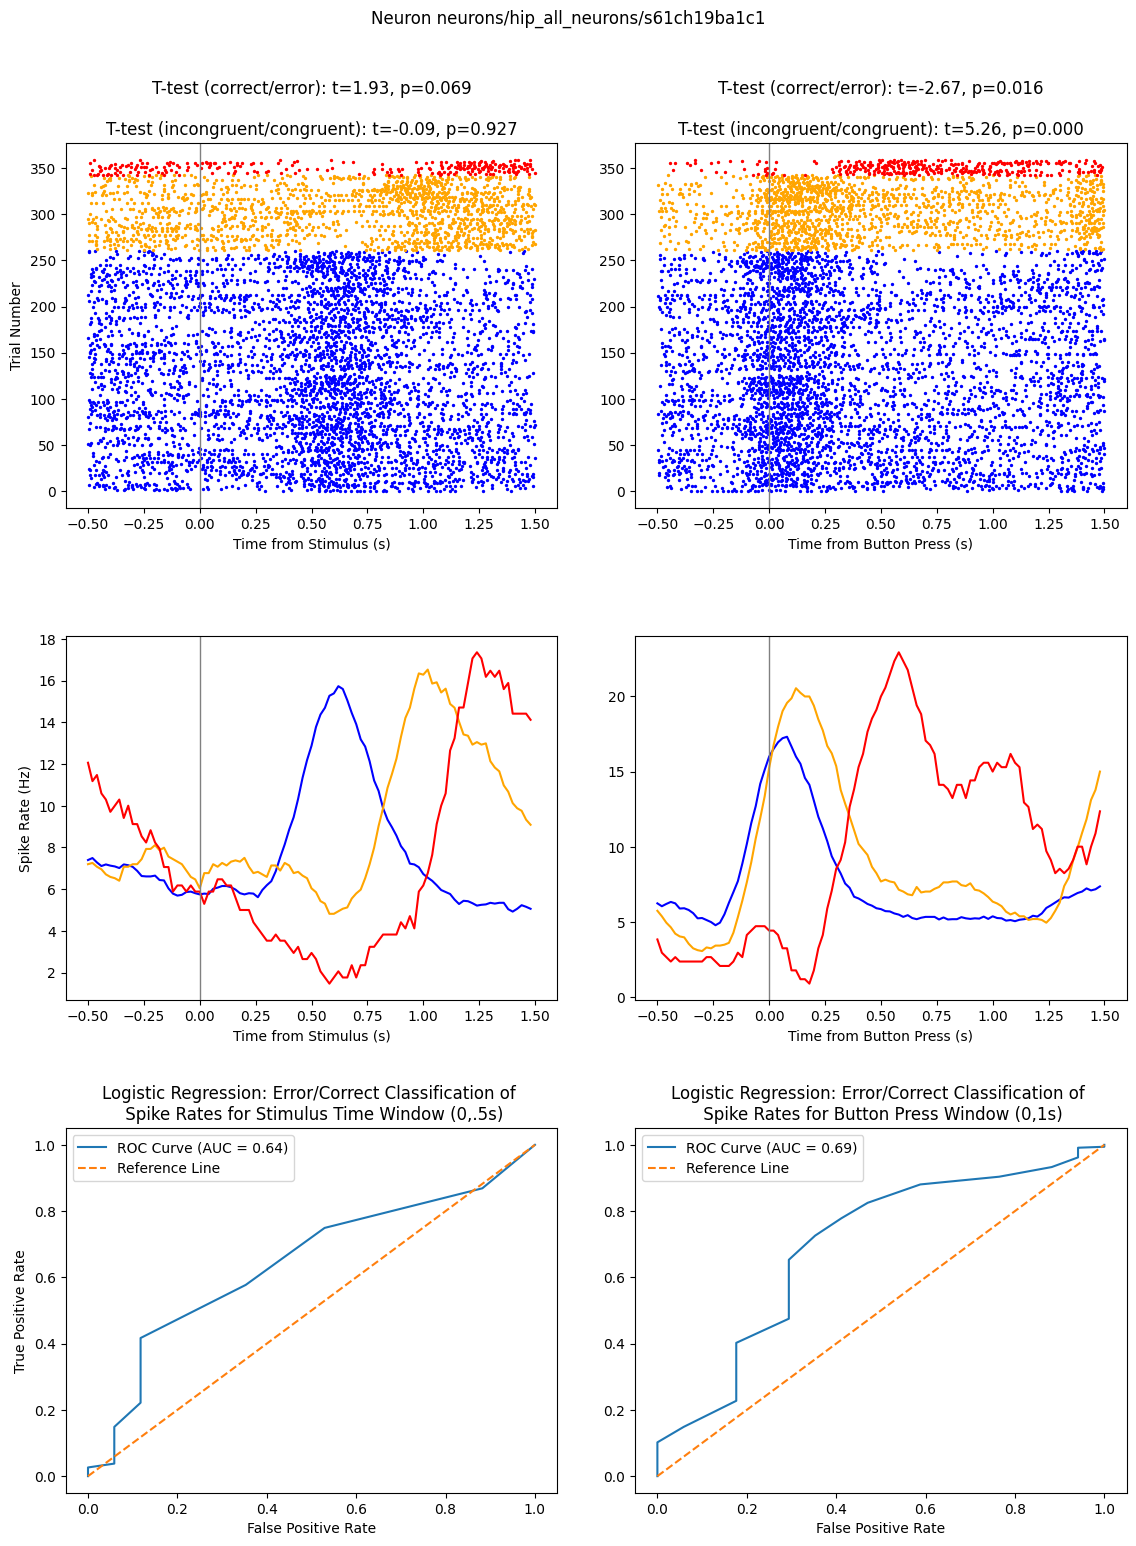

In [11]:
#Below is code for outputting a single plot for a neuron
######################################################

#define a specific mat file
test_file="neurons/hip_all_neurons/s61ch19ba1c1.mat"
    
data = load_data(test_file)
#bin the data
data, error, correctCongruent, correctIncongruent = bin_data(data)
#plot all the data
plot_data(data, error, correctCongruent, correctIncongruent, test_file, output_folder='outputs/s61ch19ba1c1')
